In [1]:
import pandas as pd
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.analysis import plotting, plotting_util, pairs_plotting
from ema_workbench import (RealParameter, ScalarOutcome, Constant,
                           Model, MultiprocessingEvaluator, SequentialEvaluator, ema_logging,
                           perform_experiments, Policy, Scenario)
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
from ema_workbench import Constraint
from ema_workbench.util.utilities import (save_results, load_results)
import seaborn as sns


In [2]:
# test model to explore initial results
ema_logging.log_to_stderr(ema_logging.INFO)

model, functions = get_model_for_problem_formulation(2)
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios=250,               #500
                                            policies=5,
                                            uncertainty_sampling='lhs')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 250 scenarios * 5 policies * 1 model(s) = 1250 experiments
[MainProcess/INFO] 125 cases completed
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 375 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 625 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 875 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1125 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [3]:
experiments = results[0]
outcomes = pd.DataFrame(results[1])
outcomes

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Minimum water level full network
0,5.911635e+06,6.330518e+08,4.004000e+08,133.865187,0.001482,4.418500
1,8.447161e+06,6.330518e+08,4.004000e+08,312.851330,0.003428,4.418500
2,1.955452e+08,6.330518e+08,4.004000e+08,6546.747295,0.064660,4.418500
3,2.878366e+07,6.330518e+08,4.004000e+08,655.238422,0.007169,4.418500
4,2.402898e+08,6.330518e+08,4.004000e+08,5615.166411,0.070590,4.418500
...,...,...,...,...,...,...
1245,1.781126e+07,6.320622e+08,1.773500e+09,0.000000,0.011392,4.418500
1246,2.394579e+06,6.320622e+08,1.773500e+09,0.000000,0.002853,4.418500
1247,4.409842e+07,6.320622e+08,1.773500e+09,0.000000,0.020683,4.418500
1248,1.760024e+05,6.320622e+08,1.773500e+09,0.000000,0.000147,4.418500


In [9]:
# Information used to set ranges
outcomes.describe()

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Minimum water level full network
count,1.250000e+03,1.250000e+03,1.250000e+03,1250.000000,1250.000000,1250.000000
mean,5.377865e+07,6.684289e+08,1.053440e+09,2588.689590,0.010820,4.443477
std,1.129787e+08,8.079243e+07,4.768800e+08,6248.646684,0.022129,0.227302
min,0.000000e+00,6.001405e+08,4.004000e+08,0.000000,0.000000,4.178387
25%,9.650884e+05,6.320622e+08,7.163000e+08,0.000000,0.000276,4.298500
50%,9.281369e+06,6.330518e+08,1.045200e+09,210.607697,0.002401,4.418500
75%,4.091784e+07,6.502151e+08,1.331800e+09,1712.123316,0.009729,4.538500
max,7.805507e+08,8.266751e+08,1.773500e+09,58046.988332,0.203609,5.556288


In [12]:
save_results(results, 'ANALYSIS_results/01_model_run.tar.gz')

[MainProcess/INFO] results saved successfully to c:\Users\bruno\github\EPA1361\lab_sessions\final assignment\firstsim.tar.gz


In [2]:
results = load_results('ANALYSIS_results/01_model_run.tar.gz')

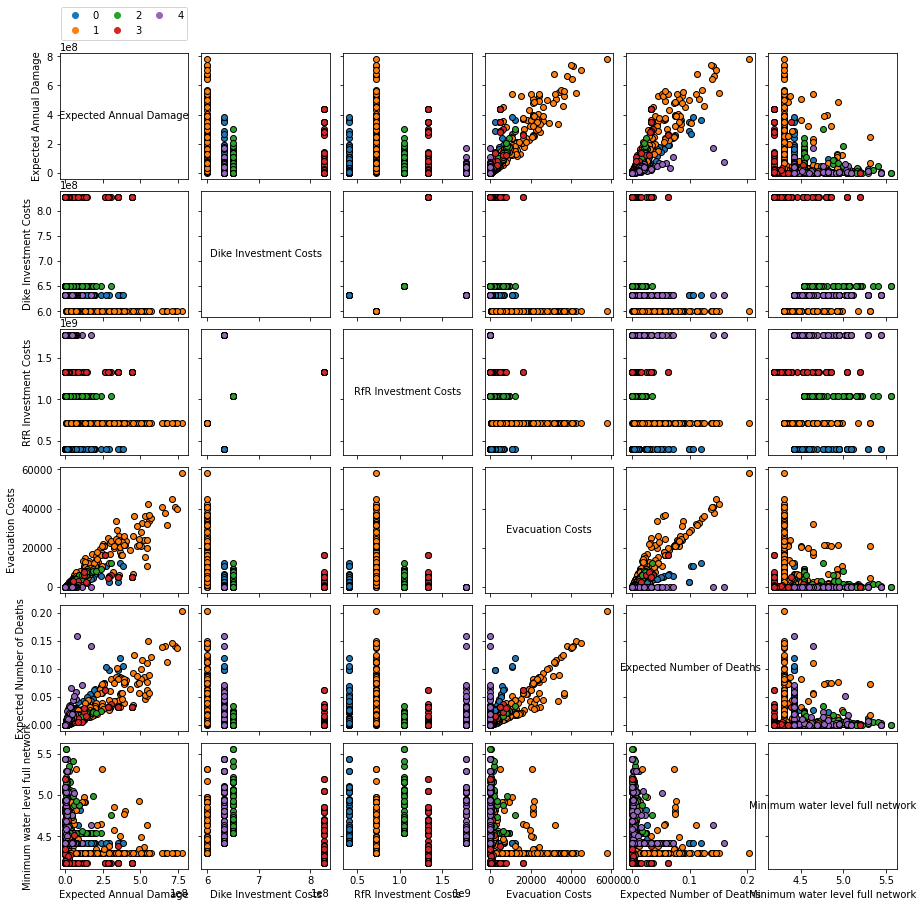

In [3]:
import matplotlib.pyplot as plt
fig, axes = pairs_plotting.pairs_scatter(results[0], results[1], group_by='policy',
                                         legend=True)
fig.set_size_inches(15,15)
plt.show()

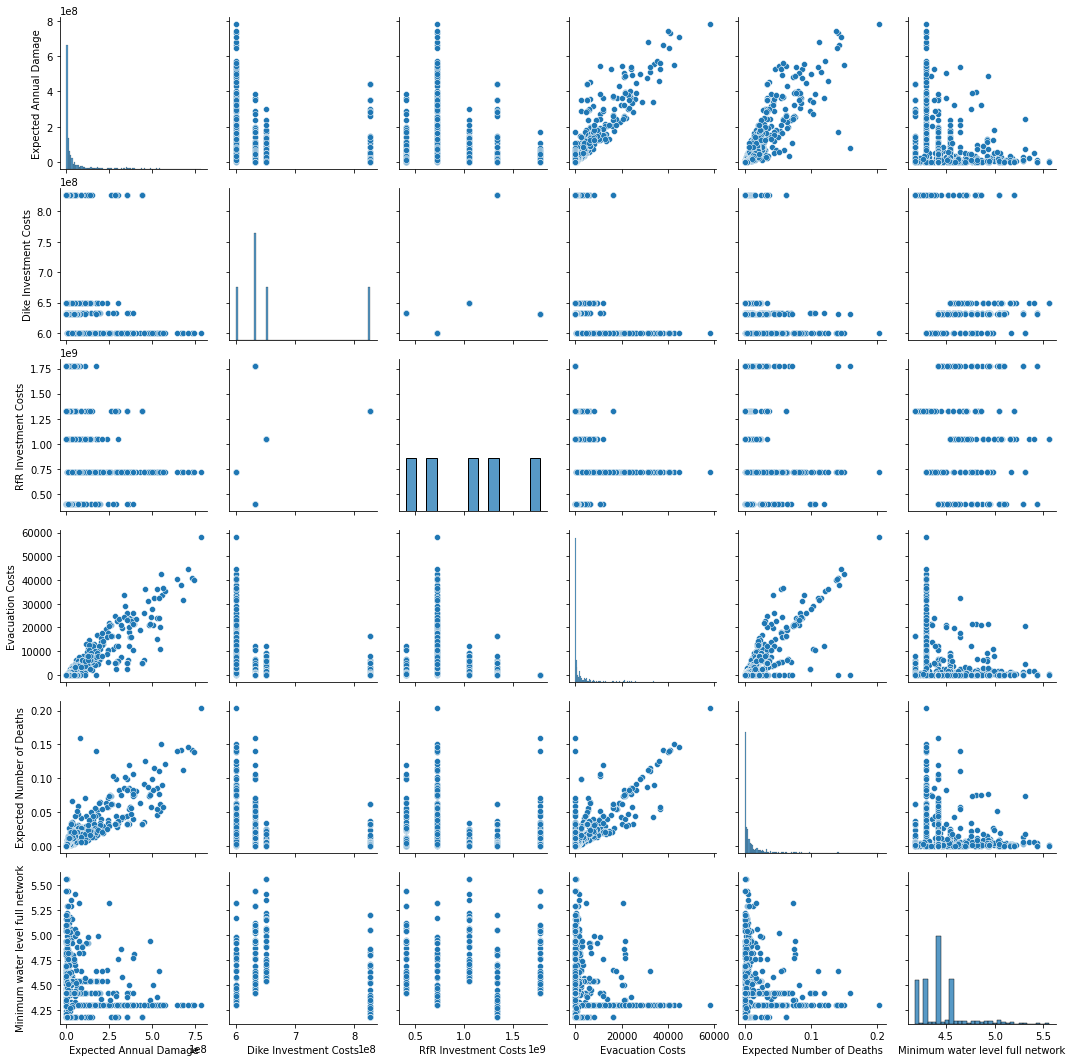

In [4]:
sns.pairplot(pd.DataFrame(results[1]))

In [7]:
# define problem formulation
model, functions = get_model_for_problem_formulation(2)

In [8]:
# set up robust functions
import functools
import numpy as np


def robustness(direction, threshold, data):
    if direction == 'SMALLER':
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

Expected_Annual_Damage = functools.partial(robustness, 'SMALLER', 1*10**6)
Dike_Investment_Costs = functools.partial(robustness, 'SMALLER', 10*10**8)	
RfR_Investment_Costs = functools.partial(robustness, 'SMALLER', 1)	
Evacuation_Costs = functools.partial(robustness, 'SMALLER', 50000)	
Expected_Number_of_Deaths = functools.partial(robustness, 'SMALLER', 1)
Minimum_water_level_full_network = functools.partial(robustness, 'LARGER', 4)



In [9]:
# Defining the robustness functions
robust = [ScalarOutcome('Expected_Damage', kind=ScalarOutcome.MAXIMIZE, variable_name='Expected Annual Damage',
                        function=Expected_Annual_Damage),
          ScalarOutcome('Dike_Costs', kind=ScalarOutcome.MAXIMIZE,variable_name='Dike Investment Costs',
                        function=Dike_Investment_Costs),
          ScalarOutcome('RfR_Costs', kind=ScalarOutcome.MAXIMIZE, variable_name='RfR Investment Costs', 
                        function=RfR_Investment_Costs),
          ScalarOutcome('Evacuation_Costs', kind=ScalarOutcome.MAXIMIZE, variable_name='Evacuation Costs',
                        function=Evacuation_Costs),
          ScalarOutcome('Number_of_Deaths', kind=ScalarOutcome.MAXIMIZE, variable_name='Expected Number of Deaths',
                        function=Expected_Number_of_Deaths),
          ScalarOutcome('wl', kind=ScalarOutcome.MAXIMIZE, variable_name='Minimum water level full network',
                        function=Minimum_water_level_full_network)   
          ]

In [10]:
convergence_metrics = [HyperVolume.from_outcomes(model.outcomes),
                       EpsilonProgress()]

In [ ]:
# function to check epsilon and convergence
def plot_epsilon_and_convergence(convergencedata):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
    ax1.plot(convergencedata.nfe, convergencedata.epsilon_progress)
    ax1.set_ylabel('$\epsilon$-progress')
    ax2.plot(convergencedata.nfe, convergencedata.hypervolume)
    ax2.set_ylabel('hypervolume')

    ax1.set_xlabel('number of function evaluations')
    ax2.set_xlabel('number of function evaluations')
    plt.show()

In [11]:
# perform MORO
ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(model) as evaluator:
    robust_results, convergence = evaluator.robust_optimize(robust, 
                                                    scenarios=1000,
                                                    nfe = 100,
                                                    epsilons=[300000, 300000, 3000000, 30000, 0.1, 0.2],
                                                    convergence=convergence_metrics,
                                                    uncertainty_sampling='lhs')

                                                    #epsilons=[300000, 300000, 3000000, 30000, 0.1, 0.2],

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/100 nfe
[MainProcess/INFO] optimization completed, found 2 solutions
[MainProcess/INFO] terminating pool


In [13]:
robust_results

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected_Damage,Dike_Costs,RfR_Costs,Evacuation_Costs,Number_of_Deaths,wl
0,0,0,0,0,0,0,0,0,0,0,...,4,0,8,3,0.0,1.0,1.0,1.0,1.0,1.0
1,0,0,0,1,1,0,0,1,0,1,...,9,7,8,5,1.0,1.0,0.0,1.0,1.0,1.0


In [ ]:
plot_epsilon_and_convergence(convergence)

In [ ]:
result.to_csv('ANALYSIS_results/01_MORO_results.csv')
convergence.to_csv('ANALYSIS_results/01_MORO_convergence.csv')